In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('../../zmult/Si110_20x14x1.dat', delimiter='\t', skiprows=2, )

In [3]:
class NearestNeighbor:
    def __init__(self, data):
        self.data = data
        unique_xpos = np.unique(data[:, 1])
        unique_ypos = np.unique(data[:, 2])
        unique_zpos = np.unique(data[:, 3])
        
        self.xpos = dict(zip(unique_xpos, range(len(unique_xpos))))
        self.invert_xpos = {v: k for k, v in self.xpos.items()}
        self.invert_xpos[len(unique_xpos)] = unique_xpos[0]
        self.invert_xpos[-1] = unique_xpos[-1]
        
        self.ypos = dict(zip(unique_ypos, range(len(unique_ypos))))
        self.invert_ypos = {v: k for k, v in self.ypos.items()}
        self.invert_ypos[len(unique_ypos)] = unique_ypos[0]
        self.invert_ypos[-1] = unique_ypos[-1]
        
        self.zpos = dict(zip(unique_zpos, range(len(unique_zpos))))
        self.invert_zpos = {v: k for k, v in self.zpos.items()}
        self.invert_zpos[len(unique_zpos)] = np.NAN
        self.invert_zpos[-1] = np.NAN

    def downNN(self, atom):
        atom = self.data[atom]
        nn = np.where(((self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] + 1]) | 
                       (self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] - 1])) & 
                      (self.data[:, 2] == atom[2]) & 
                      (self.data[:, 3] == self.invert_zpos[self.zpos[atom[3]] + 1]))[0]

        if len(nn) == 0:
            return None
        return nn[0], self.data[nn]

    def upNN(self, atom):
        atom = self.data[atom]
        nn = np.where(((self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] + 1]) | 
                       (self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] - 1])) & 
                      (self.data[:, 2] == atom[2]) & 
                      (self.data[:, 3] == self.invert_zpos[self.zpos[atom[3]] - 1]))[0]

        if len(nn) == 0:
            return None
        return nn[0], self.data[nn]

    def leftNN(self, atom):
        atom = self.data[atom]
        nn = np.where(((self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] + 1]) | 
                       (self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] - 1])) & 
                      (self.data[:, 2] == self.invert_ypos[self.ypos[atom[2]] + 1]) & 
                      (self.data[:, 3] == atom[3]))[0]

        return nn[0], self.data[nn]
        
    def rightNN(self, atom):
        atom = self.data[atom]
        nn = np.where(((self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] + 1]) | 
                       (self.data[:, 1] == self.invert_xpos[self.xpos[atom[1]] - 1])) & 
                      (self.data[:, 2] == self.invert_ypos[self.ypos[atom[2]] - 1]) & 
                      (self.data[:, 3] == atom[3]))[0]
        return nn[0], self.data[nn]
    
    

In [4]:
#data format
# 0: atom species
# 1: x (0~1)
# 2: y (0~1)
# 3: z (0~1)
# 4: occupancy
def thickness_adjust(data, layers):
    '''
        Adjust the thickness of the slab by adding repeating layers
        layers: number of layers to add
        return: new data
    '''
    #repeat the data
    new_data = np.tile(data, (layers, 1))
    #adjust the z coordinate
    new_data[:, 3] = new_data[:, 3]/layers + 1/layers*np.repeat(np.arange(layers), len(data))
    return new_data
    

In [5]:
layers = 50
new_data = thickness_adjust(data, layers)

In [6]:
nn = NearestNeighbor(new_data.copy())

In [7]:
# no coupling
unique_values = np.unique(data[:, 1])[::2]
rng = np.random.default_rng()
dopant = rng.choice(np.where(np.isin(new_data[:, 1], unique_values))[0], int(new_data.shape[0]*0.03), replace=False, shuffle=False)
unique_values = np.unique(data[:, 1])[1::2]
vacancy = rng.choice(np.where(np.isin(new_data[:, 1], unique_values))[0], int(new_data.shape[0]*0.03), replace=False, shuffle=False)
# change = rng.choice(np.arange(new_data.shape[0]), int(new_data.shape[0]*0.06), replace=False, shuffle=True)
# dopant = change[:len(change)//2]
# vacancy = change[len(change)//2:]
new_data[dopant, 0] = 2
new_data[vacancy, 0] = 0

In [7]:
# 1NN coupling
concentration = 0.015
unique_values = np.unique(data[:, 1])[1::2]

rng = np.random.default_rng()
# change = rng.choice(new_data.shape[0], int(new_data.shape[0]*concentration), replace=False, shuffle=True)
change = rng.choice(np.where(np.isin(new_data[:, 1], unique_values))[0], int(new_data.shape[0]*concentration), replace=False, shuffle=False)
# new_data[change, 0] = 0
for c in change:
    # print(c, new_data[c, 1:4])
    # vcoord = new_data[c,1:4]
    # idx = nn.upNN(c)
    # if idx is not None:
    #     new_data[idx[0], 0] = 2
    #     vec = new_data[idx[0],1:4] - vcoord

    #     if vec[0] > 0.5:
    #         vec = (new_data[idx[0],1:4] - np.array([1, 0, 0])) - vcoord
    #     elif vec[0] < -0.5:
    #         vec = (new_data[idx[0],1:4] + np.array([1, 0, 0])) - vcoord

    #     print(new_data[idx[0],1:4])    
    #     print(vcoord + vec*0.9132)
    #     new_data[idx[0],1:4] = vcoord + vec*0.9132
    # idx = nn.downNN(c)
    # if idx is not None:
    #     new_data[idx[0], 0] = 2
        # vec = new_data[idx[0],1:4] - vcoord

        # if vec[0] > 0.5:
        #     vec = (new_data[idx[0],1:4] - np.array([1, 0, 0])) - vcoord
        # elif vec[0] < -0.5:
        #     vec = (new_data[idx[0],1:4] + np.array([1, 0, 0])) - vcoord

        # print(new_data[idx[0],1:4])
        # print(vcoord + vec*0.9132)
        # new_data[idx[0],1:4] = vcoord + vec*0.9132

    idx = nn.rightNN(c)  
    if idx is not None:
        new_data[idx[0], 0] = 2
        # vec = new_data[idx[0],1:4] - vcoord
        
        # if vec[0] > 0.5:
        #     vec = (new_data[idx[0],1:4] - np.array([1, 0, 0])) - vcoord
        # elif vec[0] < -0.5:
        #     vec = (new_data[idx[0],1:4] + np.array([1, 0, 0])) - vcoord
        # if vec[1] > 0.5:            
        #     vec = (new_data[idx[0],1:4] - np.array([0, 1, 0])) - vcoord
        
        # print(new_data[idx[0],1:4])    
        # print(vcoord + vec*0.9132)
        # new_data[idx[0],1:4] = vcoord + vec*0.9132
        
    
    idx = nn.leftNN(c)           
    if idx is not None:
        new_data[idx[0], 0] = 2
        # vec = new_data[idx[0],1:4] - vcoord

        # if vec[0] > 0.5:
        #     vec = (new_data[idx[0],1:4] - np.array([1, 0, 0])) - vcoord
        # elif vec[0] < -0.5:
        #     vec = (new_data[idx[0],1:4] + np.array([1, 0, 0])) - vcoord
        # if vec[1] < -0.5:            
        #     vec = (new_data[idx[0],1:4] + np.array([0, 1, 0])) - vcoord
        # print(new_data[idx[0],1:4])
        # print(vcoord + vec*0.9132)
        # new_data[idx[0],1:4] = vcoord + vec*0.9132


## add phosphorus to match the concentration
# unique_values = np.unique(data[:, 1])[::2]

# change = rng.choice(np.where((new_data[:, 0]==1)&np.isin(new_data[:, 1], unique_values))[0], int(new_data.shape[0]*0.018), replace=False, shuffle=False)
# new_data[change, 0] = 2

# pos = new_data[:,1:4]
# pos[pos > 1] -= 1
# pos[pos < 0] += 1

In [8]:
new_data[new_data[:,1]>1]

array([], shape=(0, 5), dtype=float64)

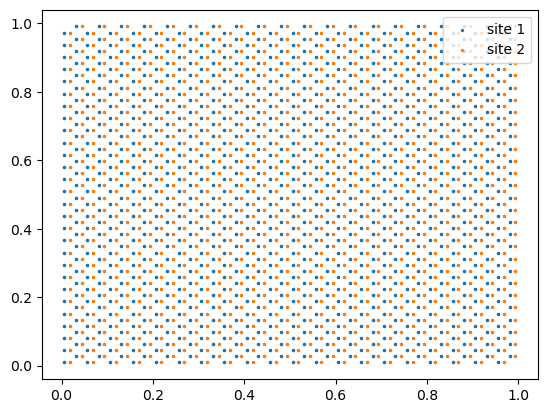

In [10]:
targetCol = data[np.isin(data[:,1],np.unique(data[:, 1])[::2])]
plt.scatter(targetCol[:,1], targetCol[:,2], s=2, label='site 1')
targetCol = data[np.isin(data[:,1],np.unique(data[:, 1])[1::2])]
plt.scatter(targetCol[:,1], targetCol[:,2], s=2, label='site 2') 
plt.legend()

In [14]:
print(np.sum(new_data[:,0]==2))

6562


1680

In [8]:
header = '''108.6000 107.5088 90.0000 {}
    {}'''.format(7.6792*layers, len(new_data[new_data[:,0]!=0]))
np.savetxt(f'dat/DP2/Si110_20x14x{layers}_P{3}percent_leftright.dat', new_data[new_data[:,0]!=0], delimiter='\t', header=header, comments='', fmt='%d\t%.7f\t%.7f\t%.7f\t%d')
np.save(f'dat/DP2/Si110_20x14x{layers}_P{3}percent_leftright.npy', new_data)

In [10]:
for concentration in np.arange(0.2, 1, 0.1):
    unique_values = np.unique(data[:, 1])[::2]
    selected_rows = new_data[np.isin(new_data[:, 1], unique_values)]
    rng = np.random.default_rng()
    change = rng.choice(selected_rows.shape[0], int(selected_rows.shape[0]*concentration), replace=False, shuffle=False)
    selected_rows[change, 0] = 2
    # selected_rows = np.delete(selected_rows, change, axis=0)
    unselected_rows = new_data[~np.isin(new_data[:, 1], unique_values)]
    res_data = np.concatenate((selected_rows, unselected_rows), axis=0)

    header = '''108.6000 107.5088 90.0000 {}
    {}'''.format(7.6792*layers, len(new_data))
    np.savetxt('dat/Si110_20x14x{}_P{}percent_in_oneColumn.dat'.format(layers, int(concentration*100)), res_data, delimiter='\t', header=header, comments='', fmt='%d\t%.7f\t%.7f\t%.7f\t%d')


In [23]:
rng = np.random.default_rng()
remove = rng.choice(new_data.shape[0]//2, int(new_data.shape[0]*0.02), replace=False, shuffle=False)
# new_data = np.delete(new_data, remove, axis=0)


In [7]:
header = '''108.6000 107.5088 90.0000 {}
{}'''.format(7.6792*layers, len(new_data))
np.savetxt('dat/Si110_20x14x{}_P{}percent_in_oneColumn.dat'.format(layers), new_data, delimiter='\t', header=header, comments='', fmt='%d\t%.7f\t%.7f\t%.7f\t%d')

$h^2 = (\frac{a}{2tan(\frac{\theta}{2})})^2 - (\frac{\sqrt{3}}{6}a)^2$
a is the original bond length, $\theta$ is the new bond angle

In [20]:
a = (np.sqrt(2)/2)
# value taken from the paper 
# Effects of Phosphorus Doping and Postgrowth Laser Annealing on the Structural, Electrical, and Chemical Properties of Phosphorus-Doped Silicon Films
# Minhyeong Lee, Hwa-Yeon Ryu, Eunjung Ko, and Dae-Hong Ko
# ACS Applied Electronic Materials 2019 1 (3), 288-301
#DOI: 10.1021/acsaelm.8b00057

theta = np.deg2rad(104.567)
# theta = np.arccos(-1/3)

h = (a / (2 * np.tan(theta / 2)))**2 - (np.sqrt(3) / 6 * a)**2
shifted = np.sqrt(h)
print(shifted)
# print(shifted - np.sqrt(h))

0.18191127680867467


In [26]:
np.sqrt(h + (np.sqrt(3)/3*a)**2)

3.432790530599446

In [12]:
np.sqrt(6)/12*(np.sqrt(2)/2)

0.14433756729740643

In [13]:
1/12*np.sqrt(3)

0.14433756729740643

(1/4, 1/4, 1/4) -> (0.2283,0.2283,0.2283)

In [23]:
((np.sqrt(3)/3 - shifted)/np.sqrt(3))/0.25

0.9132272347968658